In [1]:
# importing needed packages here

import os
import re
import spacy
import hashlib
import numpy as np
import pandas as pd

from tqdm import tqdm
from collections import Counter
from spacy.matcher import Matcher
from sklearn.metrics import accuracy_score
from nltk.tokenize import WordPunctTokenizer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer


def _hash(s):
    return hashlib.sha256(
        bytes(str(s), encoding='utf8'),
    ).hexdigest()

cpu_count = int(os.cpu_count()) if os.cpu_count() != None else 4

In [284]:
data = pd.read_csv("data/book_review_labelled_data.csv")

In [158]:
data.head()

,reviewerID,reviewerName,reviewText,overall,summary,reviewTime,rates_count,helpful_count,rating
0,A3UPFTGAWZ3G2R,David J. Loftus,"Jenkins, a history professor and Member of Par...",4,"Quite readable, nicely done","12 6, 2001",40,37,4
1,A1XTKTLNSCRLDS,Ellen Rappaport,Detective Inspector Erlendur Sveinsson is at h...,5,Mesmerizing in depth,"02 23, 2014",0,0,5
2,A1A77B6DQQH436,"crescamp ""esc""",I didn't read this. I purchased it for a gift...,3,10-minute life lessons for kids,"02 12, 2013",3,0,3
3,AEAF4MRYHJZI,"Angelia Menchan ""acvermen.blogspot.com""",Fierce Angels by Sheri Park reads like a disse...,4,So FIERCE,"03 24, 2010",9,9,4
4,A3B7KU72LGWFER,"Grifel ""Tea Time""",Clearly this author had two goals in mind: 1) ...,1,Drivel!,"06 21, 2003",19,13,1


In [275]:
np.sum(data.rates_count>0)

AttributeError: 'DataFrame' object has no attribute 'rates_count'

In [4]:
data.shape

(49992, 9)

In [5]:
len(data.reviewTime.unique())

5431

In [6]:
np.sum(data.rates_count==0)

21569

In [7]:
np.sum(data.overall-data.rating)

0

In [8]:
np.sum((data.helpful_count/data.rates_count).isnull())

21569

In [285]:
def rates_to_label(row):
    if row['rates_count'] == 0:
        val=np.nan
    elif row['helpful_count']/row['rates_count'] <= 0.5:
        val = False
    elif row['helpful_count']/row['rates_count'] > 0.5:
        val = True
    return val

In [286]:
data['label'] = data.apply(rates_to_label, axis=1)

In [287]:
data.dropna(inplace=True)
data.drop(["reviewerID", "rates_count", "helpful_count"], axis=1, inplace=True)

In [280]:
data.head()

,reviewerName,reviewText,overall,summary,reviewTime,rating,label
0,David J. Loftus,"Jenkins, a history professor and Member of Par...",4,"Quite readable, nicely done","12 6, 2001",4,True
2,"crescamp ""esc""",I didn't read this. I purchased it for a gift...,3,10-minute life lessons for kids,"02 12, 2013",3,False
3,"Angelia Menchan ""acvermen.blogspot.com""",Fierce Angels by Sheri Park reads like a disse...,4,So FIERCE,"03 24, 2010",4,True
4,"Grifel ""Tea Time""",Clearly this author had two goals in mind: 1) ...,1,Drivel!,"06 21, 2003",1,True
5,"isala ""Isabel and Lars""",This is a collection of stories and memories b...,5,Compelling stories by ordinary people,"03 19, 2005",5,True


In [288]:
#check the data size and distribution of classes:
def get_data_stats(X, y):
    print(f"Size of dataset: {len(X)}")
    unique, counts = np.unique(y, return_counts=True)
    print(f"Distribution of classes: {dict(zip(unique, counts))}")

get_data_stats(data, data.label)

Size of dataset: 28423
Distribution of classes: {False: 8911, True: 19512}


In [289]:
data.label.value_counts(normalize=True)

True     0.686486
False    0.313514
Name: label, dtype: float64

In [282]:
data.head()

,reviewerName,reviewText,overall,summary,reviewTime,rating,label
0,David J. Loftus,"Jenkins, a history professor and Member of Par...",4,"Quite readable, nicely done","12 6, 2001",4,True
2,"crescamp ""esc""",I didn't read this. I purchased it for a gift...,3,10-minute life lessons for kids,"02 12, 2013",3,False
3,"Angelia Menchan ""acvermen.blogspot.com""",Fierce Angels by Sheri Park reads like a disse...,4,So FIERCE,"03 24, 2010",4,True
4,"Grifel ""Tea Time""",Clearly this author had two goals in mind: 1) ...,1,Drivel!,"06 21, 2003",1,True
5,"isala ""Isabel and Lars""",This is a collection of stories and memories b...,5,Compelling stories by ordinary people,"03 19, 2005",5,True


In [290]:
df_baseline = data.drop(["reviewerName","overall", "summary", "reviewTime"], axis=1)

In [291]:
df_baseline.label = df_baseline.label.astype(str)

In [292]:
df_baseline

,reviewText,rating,label
0,"Jenkins, a history professor and Member of Par...",4,True
2,I didn't read this. I purchased it for a gift...,3,False
3,Fierce Angels by Sheri Park reads like a disse...,4,True
4,Clearly this author had two goals in mind: 1) ...,1,True
5,This is a collection of stories and memories b...,5,True
...,...,...,...
49982,Daniel Klein is the co-author (with Thomas Cat...,4,True
49983,This Golden Book has been around since 1962. ...,5,True
49987,I was initially attracted to this book because...,5,True
49990,Intriguing mystery and compelling romance. Cha...,5,True


In [175]:
class Selector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a column from the dataframe to perform additional transformations on
    """ 
    def __init__(self, key):
        self.key = key
        
    def fit(self, X, y=None):
        return self
    

class TextSelector(Selector):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def transform(self, X):
        return X[self.key]
    
    
class NumberSelector(Selector):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def transform(self, X):
        return X[[self.key]]
    
    

In [310]:
text = Pipeline([
                ('selector', TextSelector("reviewText")),
                ('tfidf', TfidfVectorizer())
            ])

rating =  Pipeline([
                ('selector', NumberSelector("rating")),
                ('standard', StandardScaler())
            ])

reviewAge =  Pipeline([
                ('selector', NumberSelector("reviewAge")),
                ('standard', StandardScaler())
            ])

isPerson =  Pipeline([
                ('selector', NumberSelector("is_person")),
                ('standard', StandardScaler())
            ])

In [311]:
# Feature Union allow us to use multiple distinct features in our classifier
feats = FeatureUnion([('text', text), 
                      ('rating', rating),
                     #("reviewAge", reviewAge),
                      ("isPerson", isPerson),
                     
                     
                     ])

In [308]:
# Split in train and validation
train_data, test_data = train_test_split(df_baseline, test_size=0.2, stratify=df_baseline.label)

pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 41)),
])

pipeline.fit(train_data.drop(["label"], axis=1), train_data.label)

preds = pipeline.predict(test_data.drop(["label"], axis=1))
np.mean(preds == test_data.label)

0.7115215479331575

In [294]:
data_all=pd.read_csv("data/book_review_labelled_data.csv")
data_all = data_all[data_all["rates_count"]>0]
data_all["reviewTime"] = pd.to_datetime(data_all.reviewTime)

In [295]:
df_baseline["reviewAge"] = (datetime.datetime.now()-data_all.reviewTime).astype('timedelta64[D]')

In [312]:
# Split in train and validation
train_data, test_data = train_test_split(df_baseline, test_size=0.2, stratify=df_baseline.label)

pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 41)),
])

pipeline.fit(train_data.drop(["label"], axis=1), train_data.label)

preds = pipeline.predict(test_data.drop(["label"], axis=1))
np.mean(preds == test_data.label)

0.7115215479331575

In [313]:
df_baseline

,reviewText,rating,label,reviewAge,is_person
0,"Jenkins, a history professor and Member of Par...",4,True,7276.0,True
2,I didn't read this. I purchased it for a gift...,3,False,3190.0,False
3,Fierce Angels by Sheri Park reads like a disse...,4,True,4246.0,True
4,Clearly this author had two goals in mind: 1) ...,1,True,6714.0,False
5,This is a collection of stories and memories b...,5,True,6077.0,False
...,...,...,...,...,...
49982,Daniel Klein is the co-author (with Thomas Cat...,4,True,3199.0,True
49983,This Golden Book has been around since 1962. ...,5,True,5525.0,False
49987,I was initially attracted to this book because...,5,True,4695.0,False
49990,Intriguing mystery and compelling romance. Cha...,5,True,3533.0,True


In [300]:
# Split in train and validation
train_data, test_data = train_test_split(df_baseline, test_size=0.2, stratify=df_baseline.label)

pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 41)),
])

pipeline.fit(train_data.drop(["label"], axis=1), train_data.label)

preds = pipeline.predict(test_data.drop(["label"], axis=1))
np.mean(preds == test_data.label)

0.7104661389621811

,reviewText,rating,label,reviewAge
15762,"Hattie Kong, the protagonist in Gish Jen's lat...",3,True,3927.0
39709,This exciting well written memoir by Fred Burt...,5,True,4902.0
29985,The latest installment of the &#34;Freak&#34; ...,4,True,2714.0
15415,I read several of the 1 star reviews of this b...,5,False,3299.0
13387,"Karen Abbott's first book, Sin in the Second C...",4,True,3944.0
...,...,...,...,...
9042,I've become a somewhat avid reader of fiction ...,3,True,5359.0
38939,I bought this book in order to study the kinds...,4,True,7605.0
3171,"Ghost Writer, is a small on length, but big on...",4,False,6631.0
34441,Tight prose and a gripping story - hard to bel...,5,False,2710.0


<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

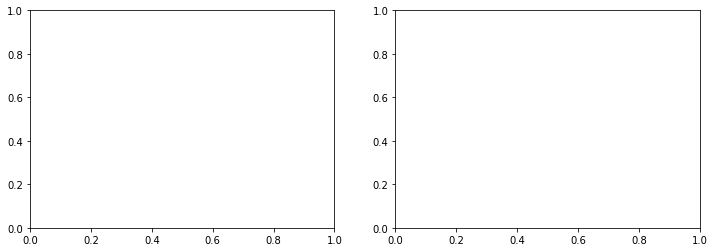

In [64]:
ax_list = data.hist(column='length', by='label', bins=50,figsize=(12,4))
ax_list[0].set_xlim((0,25000))
ax_list[1].set_xlim((0,25000))

In [24]:
df = data.copy()
df.reviewerName

0                                David J. Loftus
2                                 crescamp "esc"
3        Angelia Menchan "acvermen.blogspot.com"
4                              Grifel "Tea Time"
5                        isala "Isabel and Lars"
                          ...                   
49982                            W. A. Carpenter
49983                             D. Blankenship
49987                                   Briggsmo
49990                            Sally Berneathy
49991              Loni Hackworth "lovin' books"
Name: reviewerName, Length: 28423, dtype: object

In [26]:
#!python -m spacy download en_core_web_sm

     |████████████████████████████████| 13.6 MB 6.4 MB/s eta 0:00:01    |████████▎                       | 3.5 MB 2.7 MB/s eta 0:00:04     |█████████████████████████▎      | 10.7 MB 6.6 MB/s eta 0:00:01
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.4
    Uninstalling pyparsing-3.0.4:
      Successfully uninstalled pyparsing-3.0.4
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [28]:
# Let's also load Spacy's model with merged entities (which will come in handy later) and stopwords
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe("merge_entities", after="ner")
en_stopwords = nlp.Defaults.stop_words

# Let's get the text of the news article processed by SpaCy - This might take a while depending on 
#   your hardware (a break to walk the dog? 🐶)
docs_name = list(tqdm(nlp.pipe(df["reviewerName"], batch_size=20, n_process=cpu_count-1), total=len(df["reviewerName"])))
#docs_review = list(tqdm(nlp.pipe(df["reviewText"], batch_size=20, n_process=cpu_count-1), total=len(df["reviewerName"])))
#docs_summary = list(tqdm(nlp.pipe(df["summary"], batch_size=20, n_process=cpu_count-1), total=len(df["reviewerName"])))


100%|████████████████████████████████████| 28423/28423 [01:48<00:00, 261.77it/s]


In [205]:
docs_review = list(tqdm(nlp.pipe(df["reviewText"][0:99], batch_size=20, n_process=cpu_count-1), total=100))


 99%|█████████████████████████████████████████▌| 99/100 [00:05<00:00, 19.60it/s]


In [29]:
# I'll reset the matcher for you
matcher = Matcher(nlp.vocab)

pattern = [[{"ENT_TYPE": "PERSON"}]] #to find people entities
matcher.add("person", pattern)

             
# do matches and save the text in a list
matches_list = []
for doc in docs_name:
    matches = matcher(doc)
    for match_id, start, end in matches:
        span = doc[start:end]
        matches_list.append(str(span))
            
# count the number of times the same Person appears on the list (hint: remember the dictionary solution...)
# only take the top 10 of the counter! THE RESULT SHOULD BE A LIST

matches_dict = dict((x,matches_list.count(x)) for x in set(matches_list))
most_common_ents = list(sorted(matches_dict.items(), key=lambda item: item[1], reverse=True))[0:10]




In [263]:
len(docs_name)

28423

In [259]:
is_person = []
for doc in docs: 
    ent_types = [token.ent_type_ for token in doc]
    is_person.append("PERSON" in ent_types)

In [265]:
df_baseline

,reviewText,rating,label,reviewAge
0,"Jenkins, a history professor and Member of Par...",4,True,7276.0
2,I didn't read this. I purchased it for a gift...,3,False,3190.0
3,Fierce Angels by Sheri Park reads like a disse...,4,True,4246.0
4,Clearly this author had two goals in mind: 1) ...,1,True,6714.0
5,This is a collection of stories and memories b...,5,True,6077.0
...,...,...,...,...
49969,Lots of great recipes. I've tried several and ...,5,True,6768.0
49977,This book is an excellent manual on how to be ...,2,False,2985.0
49978,I'll start with a confession: I literally had ...,3,True,3906.0
49980,"The book was good,kind of a wrinkle in time fe...",3,True,2856.0


In [297]:
df_baseline["is_person"] = is_person

In [206]:
punctuation_count = []
punctuation_ratio = []

for doc in docs_review: 
    pos_tags = [token.pos_ for token in doc]
    punc =  np.sum([t == "PUNCT" for t in pos_tags])
    punctuation_count.append(punc)
    punctuation_ratio.append(punc/len(pos_tags))

In [226]:
(data.reviewText=="").sum()

0

In [209]:
df.label[0:99]

0       True
2      False
3       True
4       True
5       True
       ...  
149     True
151     True
152     True
155     True
156     True
Name: label, Length: 99, dtype: object

In [203]:
df.head()

,reviewerName,reviewText,overall,summary,reviewTime,rating,label,length,is_person,reviewYear
0,David J. Loftus,"Jenkins, a history professor and Member of Par...",4,"Quite readable, nicely done",2001-12-06,4,True,1790,True,2001
2,"crescamp ""esc""",I didn't read this. I purchased it for a gift...,3,10-minute life lessons for kids,2013-02-12,3,False,117,False,2013
3,"Angelia Menchan ""acvermen.blogspot.com""",Fierce Angels by Sheri Park reads like a disse...,4,So FIERCE,2010-03-24,4,True,1557,True,2010
4,"Grifel ""Tea Time""",Clearly this author had two goals in mind: 1) ...,1,Drivel!,2003-06-21,1,True,584,False,2003
5,"isala ""Isabel and Lars""",This is a collection of stories and memories b...,5,Compelling stories by ordinary people,2005-03-19,5,True,1531,False,2005


In [71]:
np.sum(df.is_person==df.label)/len(df)

0.5602856841290504

In [90]:
df["reviewTime"] = pd.to_datetime(df.reviewTime)

In [92]:
df["reviewYear"] = pd.DatetimeIndex(df["reviewTime"]). year

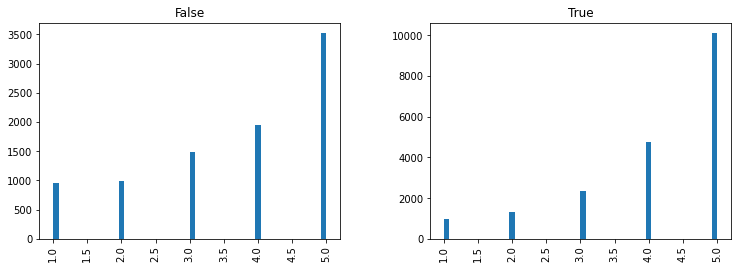

In [125]:
ax_list = df.hist(column="rating", by='label', bins=50,figsize=(12,4))
#ax_list[0].set_xlim((0,25000))
#ax_list[1].set_xlim((0,25000))

In [102]:
tokenizer = WordPunctTokenizer()

def remove_punctuation(text):
    """
    Hint: Remember the good old RegEx from 2 LUs ago
        how can I just remove everything except words, digits and spaces?
    """
    
    text = re.sub(r'[^A-Za-z\d\s]', '', text)
    #text = re.sub(' +', ' ',text)
    
    return text.lower()

def remove_stopwords(text, stopwords):
    """
    Hint: You may want to split the text into tokens using the tokenizer, it might help when searching for stopwords
        If you do, do not forget to join the tokens afterwards!
    """
    
    tokens = tokenizer.tokenize(text)
    tokens = [t for t in tokens if t not in stopwords]
    text_processed = " ".join(tokens)
    
    # Return the full string again here
    return text_processed

In [104]:
def preprocess_text(df):
    
    df_processed = df.copy()
    
    df_processed["reviewerName"] = df_processed["reviewerName"].apply(remove_punctuation)

    
    
    df_processed["reviewerName"] = df_processed["reviewerName"].apply(remove_stopwords, stopwords = en_stopwords)
    
    return df_processed

df_processed = preprocess_text(df)


In [135]:
data.reviewText[data.label==False][23]

'Philip Roth is one of those authors I would read no matter what.  He is such an excellent stylist and passionate writer that the pages just seem to drip with energy.  I relish his ability to generate confusion, excitement, disgust, interest and fascination in his work.  That\'s not to say his work doesn\'t vary in quality but, in this little story, he hits all the markers I expect and creates a great experience.Indignation tells the story of Marcus Messner, a boy who grew up in his parents\' kosher butcher shop in Newark during World War II and the years following.  It is now the early 1950\'s and, after a successful stint at a local college, he clashes with his ever-crazier father and heads to a college in a small town in Ohio.Needless to say, things don\'t get any easier for Marcus at his new place.  He has intense confrontations with his roommates, his "girlfriend," one of the deans of the school and his mother, among others.  It is a struggle to tell whether Marcus is simply going

In [155]:
data.iloc[5].reviewText


"This is a collection of stories and memories by Japanese soldiers that fought in Burma between 1942 and 1945. The collection does not intend to give a comprehensive picture of the war, or of its participants. It is a series of snapshots of war as seen by the eyes of the ordinary people that actually fight it. Neither does the collection have literary ambitions: they have just told us their stories dircetly as they experienced them, with no special narrative technique or refinement. It actually does make the book so much more powerful.Some people have complained that it is mainly about marching or waiting, well: that's what war is for ordinary soldiers: No maps, no situation reports, no overview, no moral justification. They walk in the direction they are told, the lie down when bullets start buzzing around their ears, and they try and kill the enemy before he kills them. In between actions they try and puzzle together a life away from fear.Maybe we are spoilt by the magnificent war me

In [227]:
import datetime

In [238]:
df["reviewAge"] = (datetime.datetime.now()-df.reviewTime).astype('timedelta64[D]')

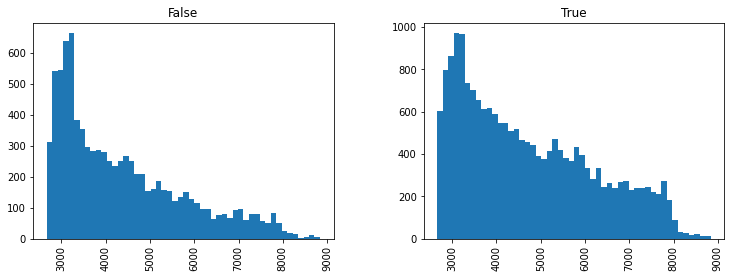

In [239]:
ax_list = df.hist(column="reviewAge", by='label', bins=50,figsize=(12,4))
#ax_list[0].set_xlim((0,25000))
#ax_list[1].set_xlim((0,25000))

In [ ]:
df.reviewAge[]